<a href="https://colab.research.google.com/github/filopacio/_python_4_analytics_nlp_project/blob/main/covid_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Covid Analysis

In [1]:
#!pip install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip install -qq twint
!pip install nest_asyncio

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import nest_asyncio
import twint 
from matplotlib import pyplot as plt

## Scrape Tweets

The package twint allows to scrape tweets without the need of API. 

Unfortunately the queries' commands were sometimes inconsistent and so some ex-post data selection and cleaning was necessary.

Also, the query was so huge that, for computational reason, less data have been downloaded. In particular, 80871 tweets have been downloaded, around 1000 tweets every 4 days during the whole time period from 01-01-2020 to 30-06-2021. 

This procedure was necessary in order to obtain less tweets than the total number but still belonging to the whole period, in order to have heterogenous tweets. 

In [ ]:
from datetime import datetime, timedelta

In [ ]:
d0 = datetime(2020, 1, 1)
d1 = datetime(2021, 6, 30)
dt = timedelta(days = 4)
dates = np.arange(d0, d1, dt).astype(datetime)

df_c = pd.DataFrame()

nest_asyncio.apply()
for i in dates:
  c = twint.Config()
  c.Search = 'covid'
  c.Until  = "{}".format(i)
  c.Lang = "en"
  c.Pandas = True
  c.Limit = 1000
  # Run
  twint.run.Search(c)
  df_c = df_c.append(twint.storage.panda.Tweets_df[['date', 'tweet','language' ,'username', 'nlikes', 'nretweets']])
  df_c.date = pd.to_datetime(df_c.date)
  df_c = df_c[df_c.language == 'en']
  df_c = df_c[df_c.date >= datetime(2020,1,1)]
  df_c.to_csv('df_c.csv')

In [ ]:
from google.colab import files

In [ ]:
files.download("df_c.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Upload dataset

In [3]:
import csv

In [4]:
with open('df_c.csv') as c:
    reader = csv.reader(c)
    l_c = list(reader)

df_c = pd.DataFrame(l_c, columns = ['','date', 'tweet','language' ,'username', 'nlikes', 'nretweets'])[1:].dropna().reset_index()
df_c = df_c[['date', 'tweet','language' ,'username']]

In [5]:
df_c.head()

,date,tweet,language,username
0,2019-12-29 05:21:25,@ross_robertross @LateRoundCorner Lamar gonna ...,en,Racist_Covid
1,2019-12-28 23:28:59,@CaslerNoel @DonaldJTrumpJr @realDonaldTrump @...,en,COVID_Careful
2,2019-12-28 23:23:01,@realDonaldTrump You do realize SF is part of ...,en,COVID_Careful
3,2019-12-28 22:16:08,I got a new mullet 🙊🙊 https://t.co/a6TBWBexG8,en,covid_mullet
4,2019-12-28 21:35:16,@IDreamOfNinja Danny needs help. I refuse to h...,en,covid_longhaul


## Preprocessing


In [6]:
import re
import string
import nltk
from nltk.corpus import stopwords
from itertools import chain
from nltk.stem.porter import PorterStemmer 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Text Cleaning**

I created the clean_text function in order to clean the tweets from noisy characters. 

items removed: 
- links
- punctuations/special characters 
- emoticons

Before doing so I also put all the texts in lower case.
I did not remove alphanumeric words to avoid eliminating words like covid19, covid-19 etc.

In [7]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('https://\S+|www\.\S', '', text)      # remove link
    text = re.sub("['’!@#$%^&*()_+<>?:.,;]" , '', text)  # punctuations/special characters
    text = re.sub(re.compile("["                        # emoticon
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
                           "]+", flags=re.UNICODE), '', text)
    return text

**Stopwords removal**

What is considered a stopword can be found in the set  below. Such list belongs to the package nltk. 

In [8]:
stopwords = set(stopwords.words('english')) 
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [9]:
def remove_stopwords(text):
    stop = set(stopwords.words('english'))  
    stop.add('im')
    stop.add("i'm")
    stop.add('could')
    stop.add('dont')
    stop.add('didnt')
    stop.add('cant')
    stop.add('thats')
    stop.add('go')
    stop.add('it')
    stop.add('get')
   # not present in the original set but very recurrent words
    text = [[i for i in i.split() if i not in stop] for i in text]
    return  text

**Lemmatization**

In [10]:
def lemmatize(text):
    lem = WordNetLemmatizer()
    corpus = [[lem.lemmatize(i, pos = 'v') for i in i] for i in text]
    return text

**Stemming**

In [11]:
def sb_stem(text):
   stemmer = SnowballStemmer(language = 'english')
   text = [stemmer.stem(i) for i in text]
   return text

In [12]:
def p_stem(text):
   stemmer = PorterStemmer()
   text = [stemmer.stem(i) for i in text]
   return text

**Final outcome of preprocessing**

In [13]:
def preprocess(text): 
  cleaned = [clean_text(i) for i in text]
  removed = remove_stopwords(cleaned)
  lemmatized = [lemmatize(i) for i in removed]
  stemmed = [p_stem(i) for i in lemmatized] 
  return lemmatized #stemmed

In [14]:
from nltk.corpus import stopwords

In [15]:
df_c['tweets'] = preprocess(df_c.tweet) 

## Sentiment Labelling

In [53]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
sent_analyzer = SentimentIntensityAnalyzer()

In [18]:
c = [sent_analyzer.polarity_scores(i) for i in df_c.tweet]
df_c['polarity'] = [i.get('compound') for i in c]

In [19]:
df_c['sentiment'] = list(np.repeat(1,len(df_c)))
for i in range(len(df_c)):
   if df_c.polarity[i] > 1/3:
     df_c['sentiment'][i] = 'positive'
   elif df_c.polarity[i] < -1/3:
        df_c['sentiment'][i] = 'negative'
   else:
        df_c['sentiment'][i] = 'neutral'

In [20]:
df_c.sentiment

0        negative
1         neutral
2        positive
3         neutral
4        positive
           ...   
80866    positive
80867    positive
80868    positive
80869    positive
80870    positive
Name: sentiment, Length: 80871, dtype: object

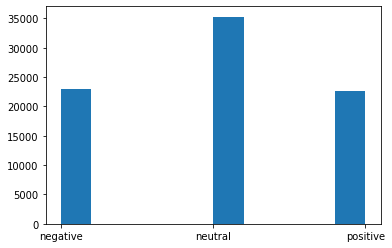

In [21]:
plt.hist(df_c.sentiment)
plt.show()

Vader's sentiment analyzer is pretty cautious, therefore it is likely not to take extremely polarized values. Consequently, under this splitting of data, the vast majority of tweets are labelled as neutral.

So let's see what happens if the 'neutral' label is removed, letting the sentiments be either 'positive' or 'negative' based, respectively, on positive or negative values of the compound.

In [22]:
sen = list(np.repeat(1,len(df_c)))
for i in range(len(df_c)):
   if df_c.polarity[i] > 0:
     sen[i] = 'positive'
   else:
    sen[i] = 'negative'

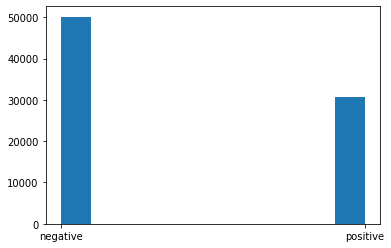

In [23]:
plt.hist(sen)
plt.show()

With a polarized labelling which doesn't consider the neutral option the difference between negative and positive tweets is clear.

## Analysis of keywords

Let us now create an even more polarized situation.

Let's take only the most polarized positive and  negative tweets in order to find (if any) differences and similarities in the use of most common words between very positive and very negative tweets.

In [24]:
df_c['polarized_sen'] = np.repeat(1,len(df_c))
for i in range(len(df_c)):
   if df_c.polarity[i] > 0.5:
     df_c['polarized_sen'].loc[i] = 'positive'
   elif df_c.polarity[i] < -0.5:
        df_c['polarized_sen'].loc[i] = 'negative'
   else:
        df_c['polarized_sen'].loc[i] = 'neutral'

In [25]:
df_c_neg = df_c[df_c.polarized_sen == 'negative'].reset_index()
df_c_pos = df_c[df_c.polarized_sen == 'positive'].reset_index()   

In [26]:
from gensim.models import Word2Vec

In [27]:
neg_w2v = Word2Vec(df_c_neg.tweets, min_count = 600)
neg_w2v.wv.vocab.pop('-')

In [28]:
type(df_c_neg.tweets[2])

list

In [29]:
pos_w2v = Word2Vec(df_c_pos.tweets, min_count= 600)
pos_w2v.wv.vocab.pop('-')

In [30]:
n = set(list(neg_w2v.wv.vocab))
p = set(list(pos_w2v.wv.vocab))

common_elements = n.intersection(p) 

In [31]:
covid_common_neg = n - n.intersection(p)

In [32]:
covid_common_pos = p - n.intersection(p)

In [33]:
from matplotlib_venn import venn2

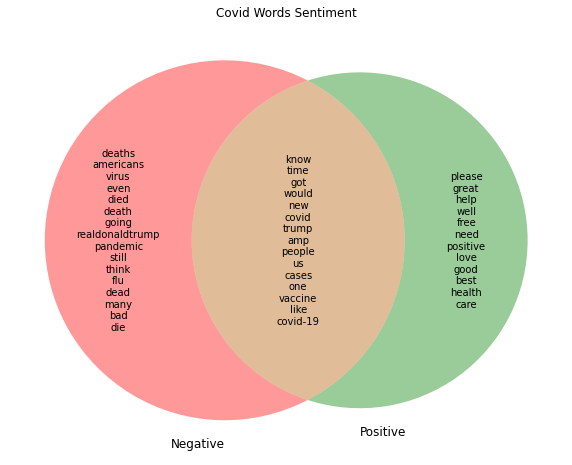

In [34]:
set1 = n
set2 = p

set_covid = n.union(p)

plt.figure(figsize=(10, 10))
venn = venn2([set1, set2], ('Negative', 'Positive'))
venn.get_label_by_id('100').set_text('\n'.join(set1-set2))
venn.get_label_by_id('110').set_text('\n'.join(set1&set2))
venn.get_label_by_id('010').set_text('\n'.join(set2-set1))
plt.title('Covid Words Sentiment')
plt.show()

With word2vec( ) the most common words inside the two polarized opposite sets are obtained. The results can be seen in the Venn Diagram above. Death and disease are the most incumbent topics (and interestingly also Trump) for the negative side while in the positive side there's a general sense of altruistic sentiment ('care', 'help', 'need', 'thank','please','love' etc.).

Also, it might be interesting to explore the overall difference in length between positive and negative tweets.

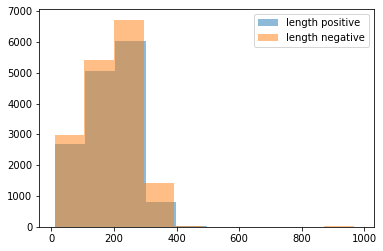

In [35]:
df_c_neg['length'] = [len(i) for i in df_c_neg.tweet]
df_c_pos['length'] = [len(i) for i in df_c_pos.tweet]

plt.hist(df_c_pos.length, label = 'length positive',alpha = 0.5)
plt.hist(df_c_neg.length, label = 'length negative', alpha = 0.5)
plt.legend(loc='upper right')
plt.show()

In [36]:
import wordcloud

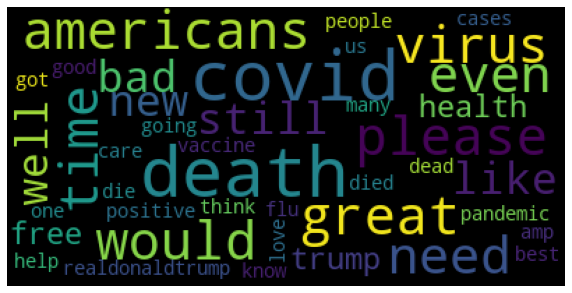

In [37]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=50, stopwords = ['dict_keys','-'])
wc = wc.generate(str(",".join(set_covid)))
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wc)
plt.show()

The results of this unigrams analysis are very similar to those obtained by (Xue, J. et al, 2020).

**Word Embedding**

Word Embedding through a Principal Component Analysis model

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [39]:
covid_w2v = Word2Vec(df_c.tweets, min_count = 1500)
covid_w2v.wv.vocab.pop('-')
covid_w2v.wv.vocab.pop('2')

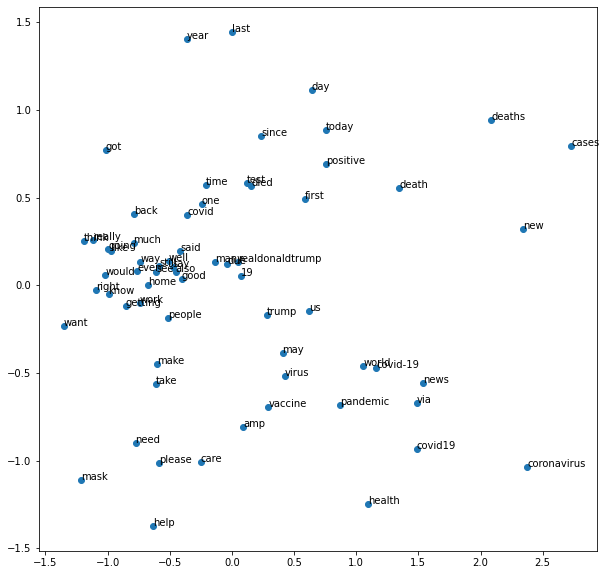

In [40]:
X = covid_w2v.wv.__getitem__(covid_w2v.wv.vocab)
pca = PCA(n_components=2)
result = pca.fit_transform(X)
plt.figure(figsize=(10, 10))
plt.scatter(result[:,0], result[:,1])
words = list(covid_w2v.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i,0], result[i,1]))
plt.show()

Interestingly, '"dynamic" words and verbs like 'do', 'get', 'work', 'take', 'go' are associated to the word 'home'.

## Introducing more articulated emotions

When dealing with a pandemic event, the distinction of sentiment only based on 'positive', 'negative', or'neutral' sentiment may be restrictive. It might be interesting to investigate more articulated emotions of tweets, and in this section this kind of investigation will be performed.


As in (Xue, J. et al, 2020), I adopted the NRC Lexycon to recognise the emotions in the tweets.

NRCLex is a package trough which more articulated sentiments can be obtained. In particular, the emotions of:

- Trust
- Fear
- Anticipation
- Anger
- Joy
- Sadness
- Disgust
- Surprise

are recognised and assigned a number from 0 to 1 based on the polarity of the emotion. There may be several emotions representing a tweet, with the sum of ther polarities being equal to 1.

For covid analysis, 5 main periods have been identified. 
Their labels are, obviously, broad approximations of reality that don't take into account singular states/regions/continents situations. 

- 1/01/2020 - 29/02/2020  : initial period, news spreading
- 1/03/2020 - 31/05/2020  : lockdown
- 1/06/2020 - 30/09/2020  : rules/laws softening
- 1/10/2020 - 31/01/2021  : new emergency
- 1/02/2021 - 30/06/2021  : vaccine campaigns

A sentiment analysis and a keywords analysis based on those 5 periods is performed in order to evaluate relevant differences. 

In [41]:
!pip install NRCLex

In [42]:
from nrclex import NRCLex
from collections import Counter
nltk.download('punkt')
from datetime import datetime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Two functions have been created to retrieve the emotions for each tweet.

- getEmotion( ) returns a dictionary where emotions and corresponding frequencies of each tweet are stored.

- EmotionSummary( ) returns a dictionary with the overall sum of frequencies of each emotion.


In [43]:
def getEmotion(sentence):
  emotion = NRCLex(sentence) 
  a_l = emotion.affect_frequencies
  return a_l

def EmotionSummary(list):
  emotions = [getEmotion(i) for i in list]
  c = Counter()
  for d in emotions:
    c.update(d)
  c = dict(c)
  c = dict(sorted(c.items(), key=lambda item: item[1], reverse=True))
  c.pop('negative')   
  c.pop('positive')
  c.pop('anticip')
  return c

In [44]:
df_c.date = pd.to_datetime(df_c.date)

In [45]:
covid_p1 = df_c[df_c.date < datetime(2020,2,29)]
emotion_sum1 = EmotionSummary(covid_p1.tweet)

In [46]:
covid_p2 = df_c[df_c.date < datetime(2020,5,31)].drop(covid_p1.index)
emotion_sum2 = EmotionSummary(covid_p2.tweet)

In [47]:
covid_p3 = df_c[df_c.date < datetime(2020,9,30)].drop(covid_p2.index).drop(covid_p1.index)
emotion_sum3 = EmotionSummary(covid_p3.tweet)

In [48]:
covid_p4 = df_c[df_c.date < datetime(2021,1,31)].drop(covid_p3.index).drop(covid_p2.index).drop(covid_p1.index)
emotion_sum4 = EmotionSummary(covid_p4.tweet)

In [49]:
covid_p5 = df_c[df_c.date < datetime(2021,6,30)].drop(covid_p4.index).drop(covid_p3.index).drop(covid_p2.index).drop(covid_p1.index)
emotion_sum5 = EmotionSummary(covid_p5.tweet)

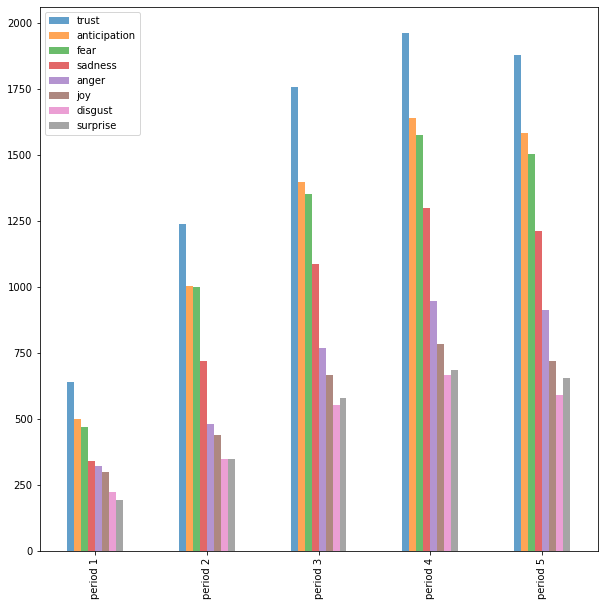

In [50]:
a = pd.DataFrame({'period 1': emotion_sum1,
             'period 2': emotion_sum2,
             'period 3': emotion_sum3,
             'period 4': emotion_sum4,
             'period 5': emotion_sum5})
a = a.transpose()
a.plot.bar(figsize=(10,10), alpha = 0.7)
plt.show()

There are not many differences among periods for what concerns prevalent emotions. 

trust, anticipation and fear are the most frequent ones.  

In [51]:
a = [ covid_p1,covid_p2,covid_p3, covid_p4, covid_p5]

p1_w2v = Word2Vec(covid_p1.tweets, min_count = 250)
p1 = set(p1_w2v.wv.vocab)

p2_w2v = Word2Vec(covid_p2.tweets, min_count = 600)
p2 = set(p2_w2v.wv.vocab)

p3_w2v = Word2Vec(covid_p3.tweets, min_count = 1000)
p3 = set(p3_w2v.wv.vocab)

p4_w2v = Word2Vec(covid_p4.tweets, min_count = 1000)
p4 = set(p4_w2v.wv.vocab)

p5_w2v = Word2Vec(covid_p5.tweets, min_count = 1000)
p5 = set(p5_w2v.wv.vocab)


p1.intersection(p2).intersection(p3).intersection(p4).intersection(p5)
p1-p1.intersection(p2).intersection(p3).intersection(p4).intersection(p5)
p2-p1.intersection(p2).intersection(p3).intersection(p4).intersection(p5)
p3-p1.intersection(p2).intersection(p3).intersection(p4).intersection(p5)
p4-p1.intersection(p2).intersection(p3).intersection(p4).intersection(p5)
p5-p1.intersection(p2).intersection(p3).intersection(p4).intersection(p5)

{'amp', 'cases', 'got', 'new', 'one', 'vaccine'}

- common words to all the periods: 

        ('covid', 'covid-19', 'like', 'people')

- mainly 1st period: 

        ('china', 'health', 'live', 'virus')

- mainly 2nd and 3rd period:

        ('amp','deaths', 'cases', 'new', 'trump')

- mainly 4th and 5th period:

        ('vaccine') 






## Download results

The resulting dataset is too heavy, therefore it has been cutted in half.

In [52]:
df_c1 = df_c.loc[:][:len(df_c)//2]
df_c2 = df_c.loc[:][len(df_c)//2:]
df_c1.to_csv('df_c_ext1.csv')
df_c1.to_csv('df_c_ext2.csv')
df_c.to_csv('df_c_ext.csv')

## Final Remarks and Conclusion


1.   Negative tweets are more common than positive ones.
2.   Negative tweets are significantly longer than positive ones.
3.   According to keywords analysis, negative tweets are mostly concerned with health, death and politics ('flu', 'pandemic', 'dead', 'event', 'trump', 'americans').
4. According to keywords analysis, positive tweets are mostly concerned with altruistic sentiments ('help', 'need', 'love', 'care') 
5. Different periods associated to relevant real-life events may be identified. Such periods are characterised by different (despite very similar) intensities of emotions and different keyword usage. Full results are available in the section 'Introducing more articulated emotions'.

## References

- Xue, J., Chen, J., Hu, R., Chen, C., Zheng, C., Su, Y., Zhu, T., *Twitter Discussions and Emotions About the COVID-19 Pandemic: Machine Learning Approach*, J Med Internet Res. 2020 Nov 25;22(11):e20550. doi: 10.2196/20550. PMID: 33119535; PMCID: PMC7690968. 

- Liang, H., Fung, I.CH., Tse, Z.T.H. et al., 2019, *How did Ebola information spread on twitter: broadcasting or viral spreading?*, BMC Public Health 19, 438 (2019). https://doi.org/10.1186/s12889-019-6747-8 

- VanderPlas, J., 2016, *Python Data Science Handbook: Essential Tools for Working with Data*, O'Reilly. 

